In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()
# Using the inspector to print the column names within the 'Salaries' table and its types
print("Columns for Measurement Table")
columns = inspector.get_columns('Measurement')
Measurment_table = []
Station_table = []
for column in columns:
    measurement_col = {}
    measurement_col["ColumnName"]= column["name"]
    measurement_col["ColumnType"]= column["type"]
    Measurment_table.append(measurement_col)

Measurment_df = pd.DataFrame(Measurment_table)  
Measurment_df
    


Columns for Measurement Table


,ColumnName,ColumnType
0,id,INTEGER
1,station,TEXT
2,date,TEXT
3,prcp,FLOAT
4,tobs,FLOAT


In [11]:
print("Columns for Station Table")   
columns = inspector.get_columns('Station')
for column in columns:
    stnt_col = {}
    stnt_col["ColumnName"]= column["name"]
    stnt_col["ColumnType"]= column["type"]
    Station_table.append(stnt_col)   
    
Station_df = pd.DataFrame(Station_table)  
Station_df

Columns for Station Table


,ColumnName,ColumnType
0,id,INTEGER
1,station,TEXT
2,name,TEXT
3,latitude,FLOAT
4,longitude,FLOAT
5,elevation,FLOAT


# Exploratory Climate Analysis

2017-08-23
<class 'list'>


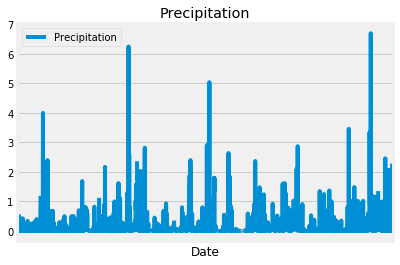

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime
last_prpt_data = session.query(Measurement.date, Measurement.prcp).\
                    order_by(Measurement.date.desc()).first()
last_date = last_prpt_data[0]
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
last_date_object = dt.datetime.strptime(last_date, "%Y-%m-%d")
lastYear = (last_date_object - datetime.timedelta(365))

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                      filter(Measurement.date >= lastYear).\
                      order_by(Measurement.date.desc()).all()
print(type(precipitation_data))
# Save the query results as a Pandas DataFrame and set the index to the date column
pcpt_df = pd.DataFrame(precipitation_data,columns=["Date","Precipitation"])
pcpt_df
# Sort the dataframe by date
pcpt_df.set_index("Date",inplace=True)
pcpt_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
pcpt_df.plot(title="Precipitation")
plt.xticks([])
plt.savefig("Images/Precipitation_Yearago.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pcpt_summ = pcpt_df.describe()
pcpt_summ

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).distinct().count()
print(station_count)
station_data = session.query(Station.station).distinct().all()
station_data

9


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#active_stations = session.query(Station.station,func.count(Station.id)).group_by(Station.station).all()
#active_stations = session.query(Station.id,Station.station,Station.name,Station.latitude,Station.longitude,\
#                                Station.elevation).all()

active_stations = session.query(Station.station,func.count(Measurement.id)).filter(Station.station == Measurement.station).\
                    group_by(Station.station).\
                    order_by(func.count(Measurement.id).desc()).all()

active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == active_stations[0][0]).all()
lowest_temp

[(54.0, 85.0, 71.66378066378067)]

2017-08-18
<class 'list'>


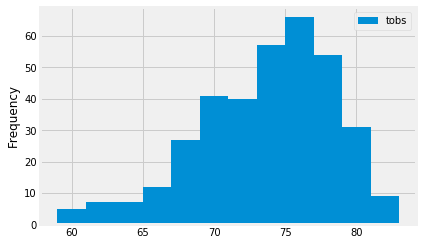

In [17]:
# Choose the station with the highest number of temperature observations.

active_station_tobs = session.query(Measurement.date,Measurement.tobs).\
                        filter(Measurement.station == active_stations[0][0]).\
                    order_by(Measurement.date.desc()).first()
active_station_tobs_last_date = active_station_tobs[0]
print(active_station_tobs_last_date)

# Calculate the date 1 year ago from the last data point in the database
act_last_date_object = dt.datetime.strptime(active_station_tobs_last_date, "%Y-%m-%d")
deltatime = (act_last_date_object - datetime.timedelta(365))

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_12_data = session.query(Measurement.tobs).\
                filter(Measurement.date >= deltatime).\
                filter(Measurement.station == active_stations[0][0]).\
                order_by(Measurement.date.desc()).all()

print(type(tobs_12_data))
# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(tobs_12_data,columns=["tobs"])
tobs_df.plot.hist(bins=12)

plt.savefig("Images/MostActiveStation_Tobs.png")
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


## Trip Dates taken is '2018-08-10' and '2018-08-15'

In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

obj = calc_temps('2017-08-10', '2017-08-15')
print(obj)
tdiff = obj[0][2]-obj[0][0]
tdiff

trip_temp_df = pd.DataFrame(obj, columns=['tmin', 'tavg', 'tmax'])
trip_temp_df.head()



[(70.0, 78.6923076923077, 84.0)]


,tmin,tavg,tmax
0,70.0,78.692308,84.0


#Plot 1 - Used the query results directly to plot data

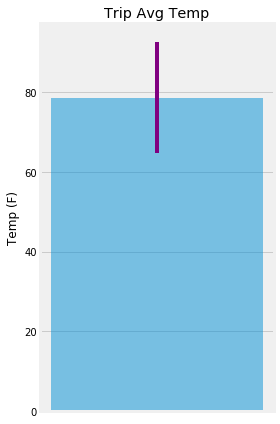

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average tTrip Avg Tempemperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig1, ax1 = plt.subplots(figsize=(4,6))
ax1.bar(1, height=obj[0][1], yerr=tdiff, alpha=0.5, align="center",ecolor='purple')
ax1.set_xticks([])
ax1.set_ylabel('Temp (F)')
ax1.set_title('Trip Avg Temp')
# Save the figure and show
plt.tight_layout()

plt.savefig("Images/TripAvgTemp.png")
plt.show()



#Plot 2 - Created a Dataframe from the query results to plot the data

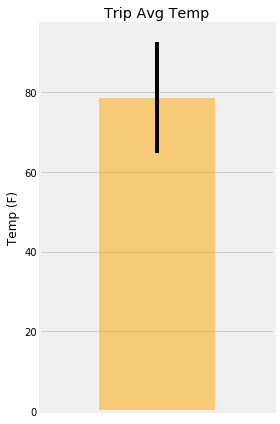

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='orange', alpha=0.5, figsize=(4,6))
plt.xticks([])
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp_Plot_Dataframe.png")
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#Trip Date is '2018-08-10' and '2018-08-15'
start_date = '2017-08-10'
end_date = '2017-08-15'
rain_per_station = session.query(Station.station,Station.name, Station.latitude,Station.longitude,\
                                 Station.elevation,Measurement.prcp,Measurement.date).\
                        filter(Station.station == Measurement.station).\
                        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                    order_by(Measurement.prcp.desc()).all()

rain_per_station

rain_per_station_df = pd.DataFrame(rain_per_station, 
                                   columns=['Station', 'Station_Name', 'Latitude','Longitude','Elevation','Precipitation','Date'])

rain_per_station_df

,Station,Station_Name,Latitude,Longitude,Elevation,Precipitation,Date
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.42,2017-08-15
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.32,2017-08-15
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.22,2017-08-14
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.14,2017-08-12
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.08,2017-08-14
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.07,2017-08-10
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.06,2017-08-15
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02,2017-08-15
8,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.01,2017-08-14
9,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00,2017-08-10


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_date = '2017-08-10'
end_date = '2017-08-15'
# Use the start and end date to create a range of dates

start_Dt = dt.datetime.strptime(start_date, "%Y-%m-%d")

end_Dt = dt.datetime.strptime(end_date, "%Y-%m-%d")
deltatime = (end_Dt - start_Dt)
no_of_days = 6
normals=[]
date_list = [start_Dt + dt.timedelta(days=x) for x in range(no_of_days)]
# Stip off the year and save a list of %m-%d strings
for date in date_list:
    normals.append(daily_normals(date.strftime("%m-%d"))[0])
# Loop through the list of %m-%d strings and calculate the normals for each date
print(normals)


[(65.0, 76.42, 83.0), (67.0, 75.98113207547169, 82.0), (67.0, 76.52727272727273, 83.0), (71.0, 76.98245614035088, 84.0), (71.0, 76.77777777777777, 82.0), (69.0, 76.47169811320755, 83.0)]


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])
normals_df["Dates"] = ['2017-08-10','2017-08-11','2017-08-12','2017-08-13','2017-08-14','2017-08-15']

normals_df.set_index("Dates", inplace=True)
normals_df

,tmin,tavg,tmax
Dates,,,
2017-08-10,65.0,76.420000,83.0
2017-08-11,67.0,75.981132,82.0
2017-08-12,67.0,76.527273,83.0
2017-08-13,71.0,76.982456,84.0
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0


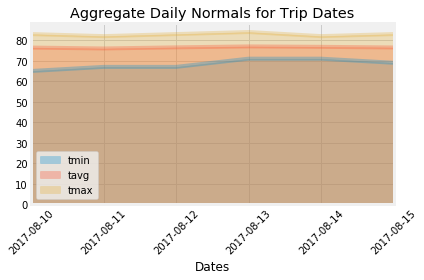

In [25]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot(kind='area', stacked=False, alpha=0.3, title="Aggregate Daily Normals for Trip Dates")

plt.legend(fancybox=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Images/DailyNormals_Area_Plot.png")
plt.show()
